In [1]:
import numpy as np
# from pathlib import Path
import os

In [2]:
# outdir =Path('/mnt/efs/fs1/mmml/WINOGROUND_BUTD')
outdir ='/output'

In [3]:
# rois = list(outdir.iterdir())
rois = os.listdir(outdir)
rois[0]

'nlvr2_ex_159_img_1.npz'

In [37]:
get_id = lambda x:int(x.split('_')[2])
get_img_i=lambda x:int(x.replace('.npz','').split('_')[-1])
rois_map = {}
for roi_file in rois:
    idx=get_id(roi_file)
    if idx not in rois_map:
        rois_map[idx]={}
    rois_map[idx][get_img_i(roi_file)]=roi_file

In [39]:
# feats = np.load(rois[0])
idx=159
img_i=1
print(rois_map[idx][img_i])
feats = np.load(os.path.join(outdir,rois_map[idx][img_i]))

nlvr2_ex_159_img_1.npz


This feature is generated by Faster R-CNN trained on Visual Genome used by BUTD (Anderson et al. 2018)

In [7]:
print(feats.files)
# features are shaped as N=NUM_BOXES x feature_dim
# N x sorted confidence per box ; 
# ROI-Pooled features (2048 dim vector); 
# normalized bbox coordinates; (x,y,x',y',w,h) where (x,y) are top left, (x',y') are bottom right
# labels from VG, (1601, 401) for object classes and attrs (attr labels not saved)
print(feats['conf'].shape,feats['features'].shape,feats['norm_bb'].shape,feats['soft_labels'].shape)

['conf', 'features', 'norm_bb', 'soft_labels']
((100, 1), (100, 2048), (100, 6), (100, 1601))


In [9]:
import cv2

In [31]:
data_path = '/src/data/genome/1600-400-20'
# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

# im_file = '/src/data/demo/000542.jpg'
im_file='/img/ex_159_img_1.png'
im = cv2.imread(im_file)

In [50]:
len(classes),len(attributes)

(1601, 401)

In [32]:
im.shape

(1788, 1920, 3)

In [29]:
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [42]:
feats['norm_bb'][0]

array([0.7656, 0.5996, 0.891 , 0.7744, 0.1251, 0.1747], dtype=float16)

In [55]:
# Get original image dimensions
image_h, image_w = im.shape[:2]
normalized_bbox = feats['norm_bb']

# Denormalize the bounding box coordinates
boxes = np.zeros_like(normalized_bbox)
boxes[:, 0] = normalized_bbox[:, 0] * image_w  # x1
boxes[:, 1] = normalized_bbox[:, 1] * image_h  # y1
boxes[:, 2] = (normalized_bbox[:, 2] + normalized_bbox[:, 4]) * image_w  # x2
boxes[:, 3] = (normalized_bbox[:, 3] + normalized_bbox[:, 5]) * image_h  # y2
# actually no need but computed for visualization code simplicity
boxes[:, 4] = normalized_bbox[:, 4] * image_w  # box width
boxes[:, 5] = normalized_bbox[:, 5] * image_h  # box height

In [59]:
cls_probs = feats['soft_labels']
objects = np.argmax(cls_probs[:,1:],axis=1)

boxes=10


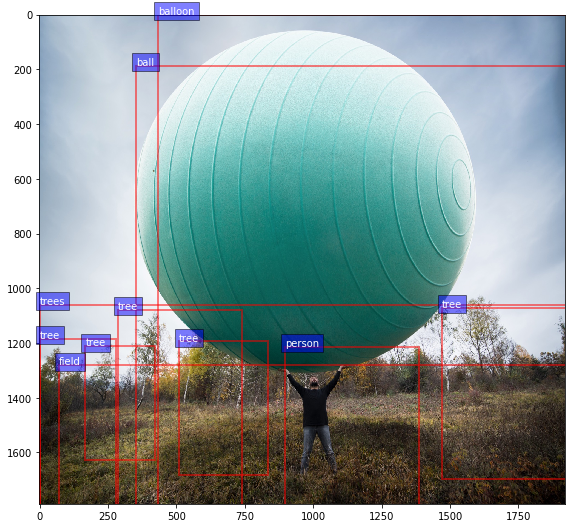

In [60]:
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img)
max_boxes=10

for i in range(max_boxes):
    bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i]+1]
#     if attr_conf[i] > attr_thresh:
#         cls = attributes[attr[i]+1] + " " + cls
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print 'boxes=%d' % (max_boxes)